# Download library

In [ ]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-d06gon66
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-d06gon66
  Resolved https://github.com/huggingface/accelerate to commit bc234c040c3703f00fca0a5b8342dd15c86e7542
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.21.0.dev0-py3-none-any.whl size=235144 sha256=ac77bef2b33c7525b8b2df216cd128331d2bb0fcdbe6996e00aa7c5f24d361aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-ani7jfk3/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3


In [ ]:
# !pip install huggingface_hub

# Load data and pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [ ]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
df_p = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_R.csv")

In [ ]:
df_p = df_p.drop(['Duration', 'comment', 'Role','combine'], axis=1)
df_r = df_r.drop(['Duration', 'comment', 'Role','combine'], axis=1)

In [ ]:
df_r = df_r.rename(columns={"Label":"label", "clean_text":"text"})
df_p = df_p.rename(columns={"Label":"label", "clean_text":"text"})

In [ ]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [ ]:
def exclude(df, labels):
  exclude_idx=[]
  for d in range(0, len(df['label'])):
      if  df['label'][d] not in labels:
          exclude_idx.append(d)
  return df.drop(index=(exclude_idx))


df_r=exclude(df_r, R_labels)
df_p=exclude(df_p, P_labels)

In [ ]:
#P_labels=['information','design action', 'failure action','failure reasoning', 'perception']

def convert_p(label):
  label=str(label)
  if label=='information':
      return 0
  elif label=='design action':
      return 1
  elif label=='failure action':
      return 2
  elif label=='failure reasoning':
      return 3
  else:
      return 4

df_p['index']=df_p['label'].apply(convert_p)

In [ ]:
#R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

def convert(label):
  label=str(label)
  if label=='introduction':
      return 0
  elif label=='clarification':
      return 1
  elif label=='workshop management':
      return 2
  elif label=='implementation':
      return 3
  else:
      return 4

df_r['index']=df_r['label'].apply(convert)

# Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [ ]:
intro_len=len(list(df_r.query('label=="introduction"').index))
cl_len=len(list(df_r.query('label=="clarification"').index))
work_len=len(list(df_r.query('label=="workshop management"').index))
imp_len=len(list(df_r.query('label=="implementation"').index))
fail_len=len(list(df_r.query('label=="failure"').index))

In [ ]:
# R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']
import random
# Return a list of indices
intro_idx=random.sample(list(df_r.query('label=="introduction"').index), 5)
cl_idx=random.sample(list(df_r.query('label=="clarification"').index),5)
work_idx=random.sample(list(df_r.query('label=="workshop management"').index),5)
imp_idx=random.sample(list(df_r.query('label=="implementation"').index),5)
fail_idx=random.sample(list(df_r.query('label=="failure"').index),5)

# Use indices to select data
train_r = df_r.loc[intro_idx + cl_idx + work_idx+ imp_idx + fail_idx]
index_list=intro_idx + cl_idx + work_idx+ imp_idx + fail_idx

In [ ]:
test_r=df_r.drop(index=(index_list))
valid_r, test_r = train_test_split(test_r, test_size=0.8)

In [ ]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# define parameters
EPOCHS = 20

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cdn-lfs.huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.746537685394287 accuracy 0.16


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.6567530714232346 accuracy 1.04

Epoch 2/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.6731152534484863 accuracy 0.32


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5979088709272187 accuracy 1.56

Epoch 3/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.459515929222107 accuracy 0.44


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.562218374219434 accuracy 5.24

Epoch 4/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.537319839000702 accuracy 0.52


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5372299408090526 accuracy 6.48

Epoch 5/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.378122329711914 accuracy 0.56


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.4718976103026291 accuracy 7.72

Epoch 6/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.1207212209701538 accuracy 0.84


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.43871349712898 accuracy 7.8

Epoch 7/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.0774431824684143 accuracy 0.76


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5546158305529891 accuracy 6.08

Epoch 8/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.948519766330719 accuracy 0.8


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.599107076381815 accuracy 5.88

Epoch 9/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.7689671218395233 accuracy 0.88


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.6438947052791202 accuracy 5.44

Epoch 10/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.6115932613611221 accuracy 0.96


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.6049647413451096 accuracy 6.08

Epoch 11/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.5436394214630127 accuracy 0.96


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.628246623894264 accuracy 6.08

Epoch 12/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.4897196888923645 accuracy 0.96


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5728721947505557 accuracy 6.5600000000000005

Epoch 13/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.4077002927660942 accuracy 0.96


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5526948057371994 accuracy 6.6000000000000005

Epoch 14/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.34650740027427673 accuracy 0.96


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.5748316090682457 accuracy 7.04

Epoch 15/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.29865049570798874 accuracy 0.96


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.6533578552048782 accuracy 6.5600000000000005

Epoch 16/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.2904471531510353 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7334979361501233 accuracy 6.28

Epoch 17/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.2391963079571724 accuracy 0.96


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7548121542766177 accuracy 6.36

Epoch 18/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.2157507799565792 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7429865721998543 accuracy 6.4

Epoch 19/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.17114876210689545 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.730723261833191 accuracy 6.5200000000000005

Epoch 20/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.17846492305397987 accuracy 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

Val loss 1.7285322115339081 accuracy 6.6000000000000005



In [ ]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.3764436032611778

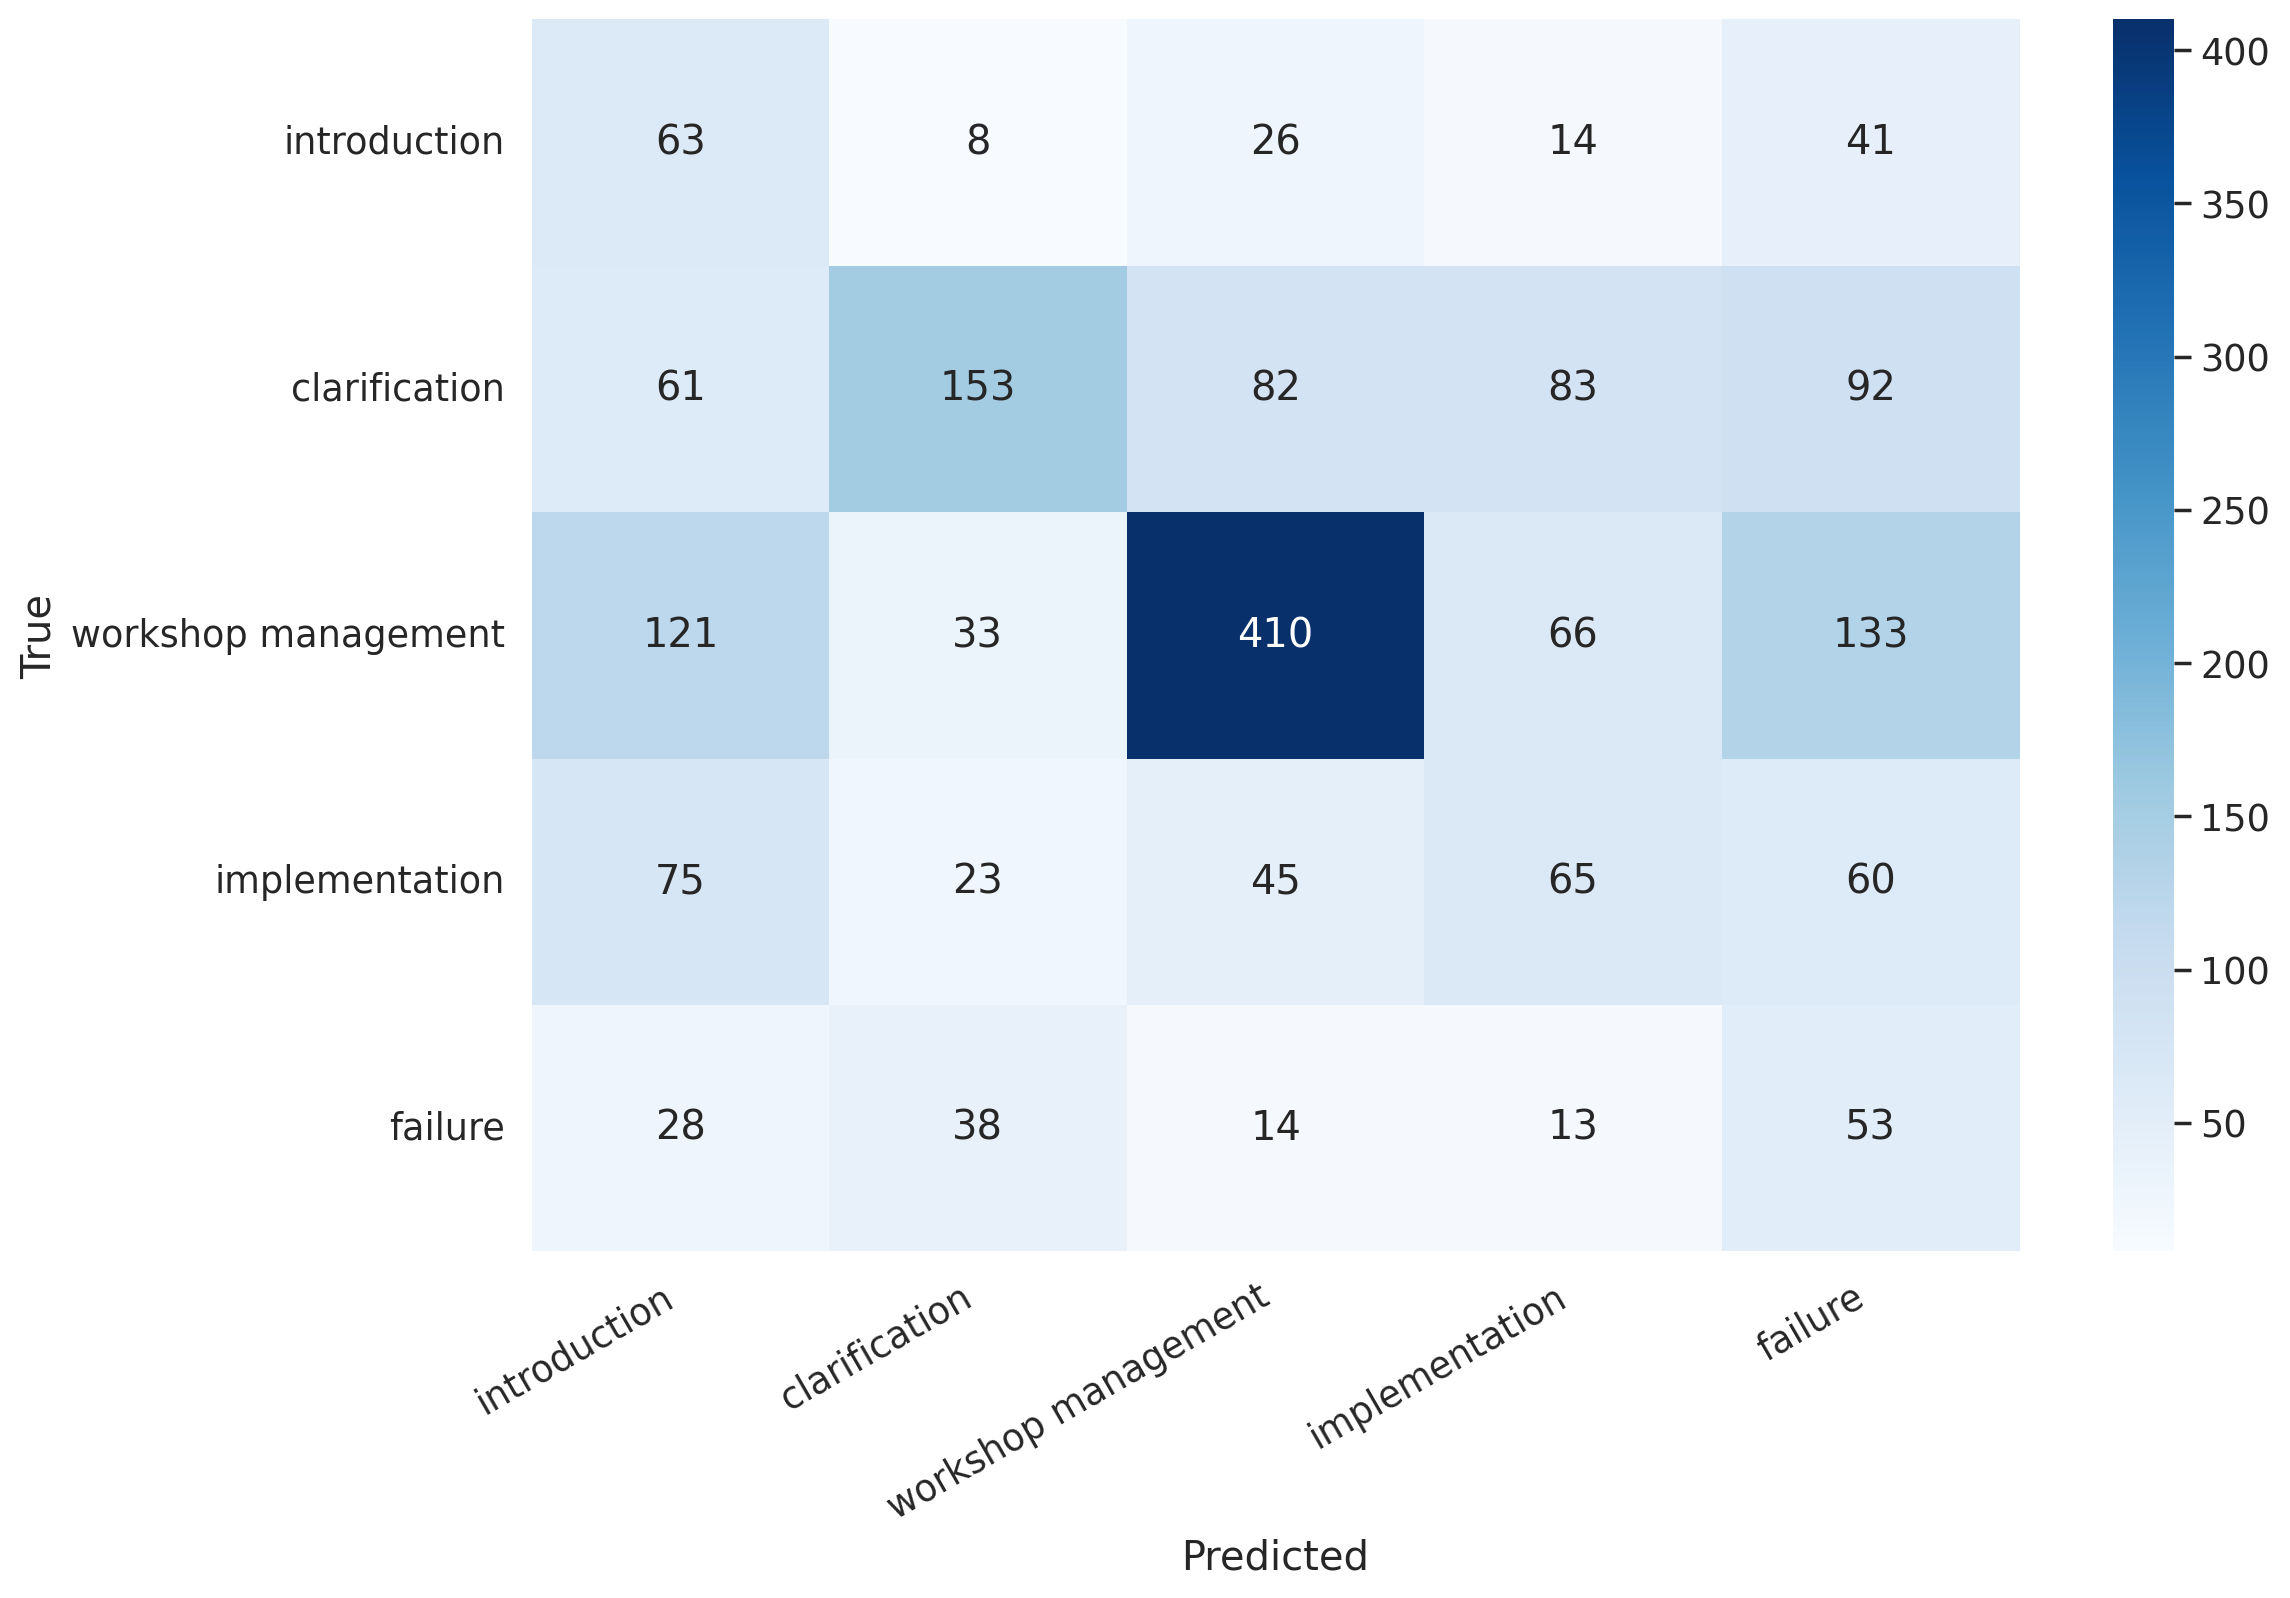

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.18      0.41      0.25       152
      clarification       0.60      0.32      0.42       471
workshop management       0.71      0.54      0.61       763
     implementation       0.27      0.24      0.26       268
            failure       0.14      0.36      0.20       146

           accuracy                           0.41      1800
          macro avg       0.38      0.38      0.35      1800
       weighted avg       0.52      0.41      0.45      1800



# Participant

In [ ]:
info_len=len(list(df_r.query('label=="introduction"').index))
des_len=len(list(df_r.query('label=="clarification"').index))
fa1_len=len(list(df_r.query('label=="workshop management"').index))
fa2_len=len(list(df_r.query('label=="implementation"').index))
per_len=len(list(df_r.query('label=="failure"').index))

In [ ]:
import random
# Return a list of indices
info_idx=random.sample(list(df_p.query('label=="information"').index),5)
des_idx=random.sample(list(df_p.query('label=="design action"').index),5)
fa1_idx=random.sample(list(df_p.query('label=="failure action"').index),5)
fa2_idx=random.sample(list(df_p.query('label=="failure reasoning"').index),5)
per_idx=random.sample(list(df_p.query('label=="perception"').index),5)

# Use indices to select data
train_p = df_p.loc[info_idx + des_idx + fa1_idx+ fa2_idx + per_idx]
index_list=info_idx + des_idx + fa1_idx+ fa2_idx + per_idx

In [ ]:
test_p=df_p.drop(index=(index_list))
valid_p, test_p = train_test_split(test_p, test_size=0.8)

In [ ]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# define parameters
EPOCHS = 20

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkp

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.8000571727752686 accuracy 0.16


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6764122765997183 accuracy 1.2

Epoch 2/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.5762669444084167 accuracy 0.28


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6514912947364475 accuracy 4.16

Epoch 3/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.6885019540786743 accuracy 0.24


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6406475875688635 accuracy 4.16

Epoch 4/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.7015443444252014 accuracy 0.28


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.632499072862708 accuracy 3.96

Epoch 5/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.5327849388122559 accuracy 0.2


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6251992298209148 accuracy 3.92

Epoch 6/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.51641446352005 accuracy 0.32


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6232758034830508 accuracy 3.0

Epoch 7/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.5702708959579468 accuracy 0.28


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6180698301481165 accuracy 2.92

Epoch 8/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.4952632784843445 accuracy 0.28


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6161036646884421 accuracy 3.04

Epoch 9/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.4459721446037292 accuracy 0.44


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.623580020406972 accuracy 3.08

Epoch 10/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.363370418548584 accuracy 0.56


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6960848103398862 accuracy 2.2

Epoch 11/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.219875991344452 accuracy 0.68


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6808019980140354 accuracy 2.64

Epoch 12/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.1915947794914246 accuracy 0.72


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.655024917229362 accuracy 3.12

Epoch 13/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.0828786492347717 accuracy 0.72


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.707558009935462 accuracy 2.7600000000000002

Epoch 14/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 1.0344699621200562 accuracy 0.84


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6903846471206 accuracy 2.8000000000000003

Epoch 15/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.9229896068572998 accuracy 0.84


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6757934611776601 accuracy 3.0

Epoch 16/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.7606310844421387 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6380448030388874 accuracy 3.36

Epoch 17/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.7022130787372589 accuracy 0.96


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6157016546829888 accuracy 3.52

Epoch 18/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.6513796150684357 accuracy 0.96


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6130771170491758 accuracy 3.68

Epoch 19/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.594819962978363 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6129130539686785 accuracy 3.64

Epoch 20/20
----------


  0%|          | 0/2 [00:00<?, ?it/s]

Train loss 0.5573085844516754 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6134919861088628 accuracy 3.68



In [ ]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.2884811230298851

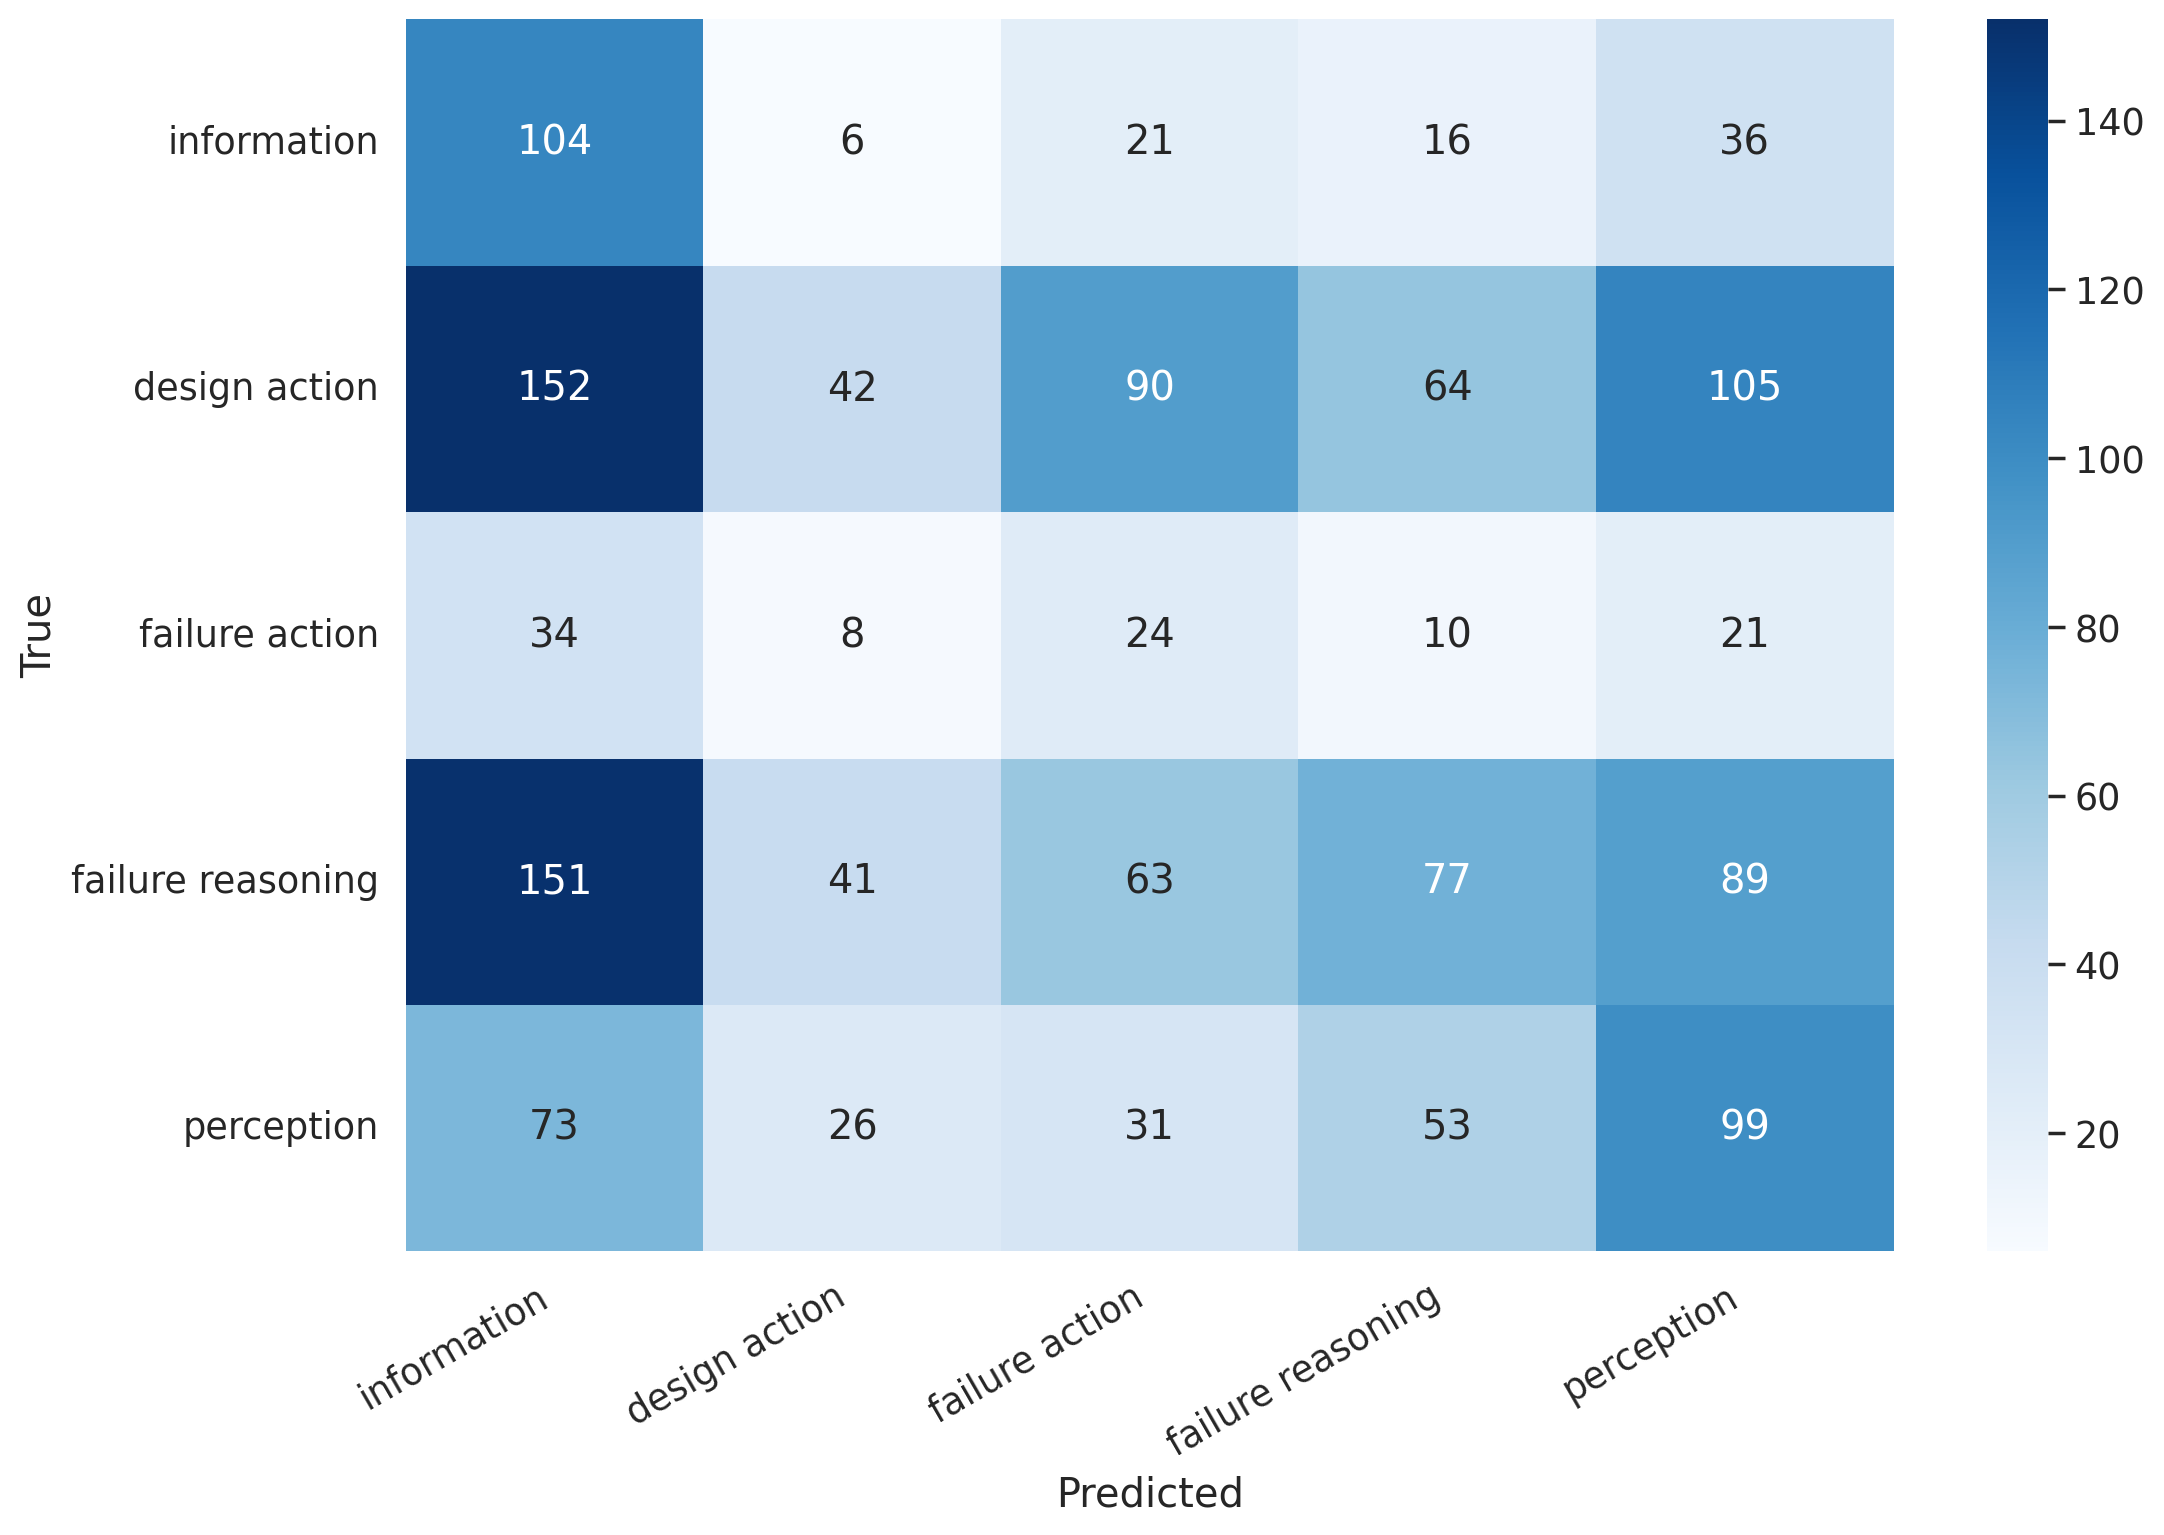

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.20      0.57      0.30       183
    design action       0.34      0.09      0.15       453
   failure action       0.10      0.25      0.15        97
failure reasoning       0.35      0.18      0.24       421
       perception       0.28      0.35      0.31       282

         accuracy                           0.24      1436
        macro avg       0.26      0.29      0.23      1436
     weighted avg       0.30      0.24      0.23      1436

